## Outline

* [1. Problem Statement](#0)
* [2. Performance Metrics](#1)
* [3. Dataset Description](#2)
* [4. Exploratory Data Analysis](#3)
    * [4.1. Loading Data](#3.1)    
    * [4.2. Data Visualisations](#3.2)
* [5. Data Preprocessing](#4)
    * [5.1. Imputing Missing Values & Categorical Encoding](#4.1)    
    * [5.2. Feature Engineering](#4.2) 

<a id='0'></a>
## 1. Problem Statement

The 80/20 rule has proven true for many businesses–only a small percentage of customers produce most of the revenue. As such, marketing teams are challenged to make appropriate investments in promotional strategies.

RStudio, the developer of free and open tools for R and enterprise-ready products for teams to scale and share work, has partnered with Google Cloud and Kaggle to demonstrate the business impact that thorough data analysis can have.

In this competition, you’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.

Objective is to predict the natural log of the sum of all transactions per user. 

<a id='1'></a>
## 2. Performance Metrics

Root Mean Squared Error

$\textbf{y}_{user}= \sum_i{\textbf{transaction}_{user}}$

$\textbf{target}_{user} = ln(\textbf{y}_{user} + 1) $

where y hat is the natural log of the predicted revenue for a customer and y is the natural log of the actual summed revenue value plus one.

<a id='2'></a>
## 3. Dataset Description

- train_v2.csv 1708337 rows x 55 columns - Size 23.6 GB
- test_v2.csv 401589 rows x 55 columns - Size 7.1 GB

Data Fields

- fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
- channelGrouping - The channel via which the user came to the Store.
- date - The date on which the user visited the Store.
- device - The specifications for the device used to access the Store.
- geoNetwork - This section contains information about the geography of the user.
- socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
- totals - This section contains aggregate values across the session.
- trafficSource - This section contains information about the Traffic Source from which the session originated.
- visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
- visitNumber - The session number for this user. If this is the first session, then this is set to 1.
- visitStartTime - The timestamp .
- hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
- customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
- totals - This set of columns mostly includes high-level aggregate data.

Due to the formatting of fullVisitorId you must load the Id's as strings in order for all Id's to be properly unique!
There are multiple columns which contain JSON blobs of varying depth. In one of those JSON columns, totals, the sub-column transactionRevenue contains the revenue information we are trying to predict. This sub-column exists only for the training data.



<a id='3'></a>
## 4. Exploratory Data Analysis

<a id='3.1'></a>
## 4.1 Loading data

In [1]:
# Necessary librarys
import os 
import random
import datetime as dt

import pandas as pd
import json
from pandas import json_normalize
import numpy as np
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Two important points when loading data
 - Multiple columns in the dataset contain JSON blobs 
 - fullVisitorId column must be loaded as string

https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82614

#### Train dataset slicing strategy based on time windows

In the test dataset, we have info on visitor sessions that occured in the 168 days period (2018/05/01 to 2018/10/15) and have been asked to predict the revenue these visitors will generate between 62 days period (2018/12/01 to 2019/01/31) for which no data is given. The 46 days (16/10/2018 to 30/11/2018) is a gap between above two windows which can be considered as cooling period.

We therefore take 4 non-overlapping windows of 168 days, calculated features for users in each period and calculate target for each user on each corresponding 62-day window. Then those 4 dataframes will be combined in one train set.

The train 23.6 GB and test 7.1 GB have
 - Train data time period range is      : Aug 1'st 2016 to Apr 30'th 2018 => total 638 days.
 - Test data time period range is       : May 1'st 2018 to Oct 15'th 2018 => total 168 days.
 - Prediction data time period range is : Dec 1'st 2018 to Jan 31'st 2019 => total 62 days. 

The train data will consist of 168 days data and test data will consist of 62 days data with a gap of 46 days between the train data end date and test data start date.

We need to predict whether the user will return to the store during our test window. 

Eg.
- Train data = 01-Aug-2016 to 15-Jan-2017 (168 days)
- Gap (46 days)
- Test data = 02-Mar-2017 to 03-May-2017 (62 days) 

We will therefore have 4 training and testing sets.
- Window-1: Train data - 01-Aug-2016 to 15-Jan-2017 (168 days) & Test data - 02-Mar-2017 to 03-May-2017 (62 days) 
- Window-2: Train data - 16-Jan-2017 to 02-Jul-2017 (168 days) & Test data - 17-Aug-2017 to 18-Oct-2017 (62 days) 
- Window-3: Train data - 03-Jul-2017 to 17-Dec-2017 (168 days) & Test data - 01-Feb-2018 to 04-Apr-2018 (62 days) 
- Window-4: Train data - 18-Dec-2017 to 04-Jun-2018 (168 days) & Test data - 20-Jul-2018 to 20-Sep-2018 (62 days) 


In [2]:
train = pd.read_csv('train_v2.csv',dtype={'fullVisitorId':'str'})

In [2]:
test = pd.read_csv('test_v2.csv',dtype={'fullVisitorId':'str'})

In [3]:
test_df = load_df('test_v2.csv')

Shape: (401589, 57)


In [4]:
test_df.to_pickle('test_df.pkl')

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 13 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   channelGrouping       object
 1   customDimensions      object
 2   date                  int64 
 3   device                object
 4   fullVisitorId         object
 5   geoNetwork            object
 6   hits                  object
 7   socialEngagementType  object
 8   totals                object
 9   trafficSource         object
 10  visitId               int64 
 11  visitNumber           int64 
 12  visitStartTime        int64 
dtypes: int64(4), object(9)
memory usage: 169.4+ MB


In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       401589 non-null  object
 1   customDimensions      401589 non-null  object
 2   date                  401589 non-null  int64 
 3   device                401589 non-null  object
 4   fullVisitorId         401589 non-null  object
 5   geoNetwork            401589 non-null  object
 6   hits                  401589 non-null  object
 7   socialEngagementType  401589 non-null  object
 8   totals                401589 non-null  object
 9   trafficSource         401589 non-null  object
 10  visitId               401589 non-null  int64 
 11  visitNumber           401589 non-null  int64 
 12  visitStartTime        401589 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 39.8+ MB


In [4]:
train["date"] = pd.to_datetime(train["date"], format="%Y%m%d")
test["date"] = pd.to_datetime(test["date"], format="%Y%m%d") 

In [5]:
min(train['date'])

Timestamp('2016-08-01 00:00:00')

In [6]:
max(train['date'])

Timestamp('2018-04-30 00:00:00')

In [5]:
min(test['date'])

Timestamp('2018-05-01 00:00:00')

In [6]:
max(test['date'])

Timestamp('2018-10-15 00:00:00')

In [ ]:
train_test = pd.concat([train, test], axis=0).reset_index()

Dividing the dataset based on the time windows determined before which will make it easier to flatten the JSON columns

In [4]:
def get_time_windows(data, period):
    
    train_slice = data.loc[(data['date'] >= min(data['date']) + dt.timedelta(days = 168 * (period-1))) 
                           & (data['date'] < min(data['date'])  + dt.timedelta(days = 168 * period))]
    
    test_slice = data.loc[(data['date'] >= max(train_slice['date']) + dt.timedelta(days = 46)) 
                    & (data['date'] <= max(train_slice['date']) + dt.timedelta(days = 108))]
    
    return train_slice, test_slice

In [5]:
#train_slice_1, test_slice_1 = get_time_windows(train, 1)
#train_slice_2, test_slice_2 = get_time_windows(train, 2)
#train_slice_3, test_slice_3 = get_time_windows(train, 3)

In [7]:
#temp_slice_train = train[(train['date'].dt.date >= dt.date(2017,12,18)) & (train['date'].dt.date <= dt.date(2018,4,30))]
temp_slice_train_2 = test[(test['date'].dt.date >= dt.date(2018,5,1)) & (test['date'].dt.date <= dt.date(2018,6,4))]
test_slice_4 = test[(test['date'].dt.date >= dt.date(2018,7,20)) & (test['date'].dt.date <= dt.date(2018,9,20))]

In [8]:
#train_slice_1.to_csv('train_slice_1.csv')
#test_slice_1.to_csv('test_slice_1.csv')
#train_slice_2.to_csv('train_slice_2.csv')
#test_slice_2.to_csv('test_slice_2.csv')
#train_slice_3.to_csv('train_slice_3.csv')
#test_slice_3.to_csv('test_slice_3.csv')
#temp_slice_train.to_csv('temp_slice_train.csv')
temp_slice_train_2.to_csv('temp_slice_train_2.csv')
test_slice_4.to_csv('test_slice_4.csv')

In [10]:
temp_slice_train.shape

(377189, 13)

In [11]:
min(temp_slice_train['date'])

Timestamp('2017-12-18 00:00:00')

In [12]:
max(temp_slice_train['date'])

Timestamp('2018-04-30 00:00:00')

In [13]:
temp_slice_train.to_csv('temp_slice_train.csv')

In [11]:
min(test_slice_3['date'])

Timestamp('2018-02-01 00:00:00')

In [12]:
max(test_slice_3['date'])

Timestamp('2018-04-04 00:00:00')

In [8]:
test_slice_3.shape

(189041, 13)

In [2]:
# Helper to load data with JSON flatten

def load_df(csv_path='train.csv'):
    columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] 
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'})
    
    df.drop(['hits','customDimensions'], axis=1, inplace=True)
    
    for column in columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Shape: {df.shape}")
    return df

In [10]:
#train_slice_1 = load_df('train_slice_1.csv')
#test_slice_1 = load_df('test_slice_1.csv')
#train_slice_2 = load_df('train_slice_2.csv')
#test_slice_2 = load_df('test_slice_2.csv')
#train_slice_3 = load_df('train_slice_3.csv')
#test_slice_3 = load_df('test_slice_3.csv')
#temp_slice_train = load_df('temp_slice_train.csv')
temp_slice_train_2 = load_df('temp_slice_train_2.csv')
test_slice_4 = load_df('test_slice_4.csv')

Shape: (97268, 58)
Shape: (139148, 58)


In [15]:
# Dropping columns which has only 1 unique value

def drop_cols(df):
    column_names = df.columns.to_list()
    for column in column_names:
        count = df[column].nunique()
        if count==1:
            del df[column]
    return df

In [12]:
#train_slice_1 = drop_cols(train_slice_1)
#test_slice_1 = drop_cols(test_slice_1)
#train_slice_2 = drop_cols(train_slice_2)
#test_slice_2 = drop_cols(test_slice_2)
#train_slice_3 = drop_cols(train_slice_3)
#test_slice_3 = drop_cols(test_slice_3)
#temp_slice_train = drop_cols(temp_slice_train)
temp_slice_train_2 = drop_cols(temp_slice_train_2)
test_slice_4 = drop_cols(test_slice_4)

In [16]:
test_df = drop_cols(test_df)

In [16]:
#train_slice_1.head()
#test_slice_1.head()
#train_slice_2.head()
#test_slice_2.head()
#train_slice_3.head()
#test_slice_3.head()
#temp_slice_train.head()
#temp_slice_train_2.head()
test_slice_4.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType
0,Direct,2018-08-19,0918475018537313399,1534679707,1,1534679707,Chrome,Chrome OS,False,desktop,...,(not set),(not set),(direct),(none),(not set),(not set),NaN,NaN,NaN,NaN
1,Organic Search,2018-08-19,3273393994176562540,1534674630,1,1534674630,Chrome,Android,True,mobile,...,(not set),(not set),google,organic,(not provided),(not set),NaN,NaN,NaN,NaN
2,Organic Search,2018-08-19,0959709737355084044,1534735290,1,1534735290,Chrome,Macintosh,False,desktop,...,(not set),(not set),google,organic,(not provided),(not set),NaN,NaN,NaN,NaN
3,Organic Search,2018-08-19,5661724214350003526,1534711214,1,1534711214,Edge,Windows,False,desktop,...,(not set),(not set),google,organic,(not provided),(not set),NaN,NaN,NaN,NaN
4,Paid Search,2018-08-19,5651987905940093007,1534740641,1,1534740641,Chrome,Windows,False,desktop,...,(not set),(not set),google,cpc,(not set),(not set),NaN,NaN,NaN,NaN


In [15]:
temp_slice_train_2.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_slice_4.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [17]:
#train_slice_1.to_pickle('train_slice_1.pkl')
#test_slice_1.to_pickle('test_slice_1.pkl')
#train_slice_2.to_pickle('train_slice_2.pkl')
#test_slice_2.to_pickle('test_slice_2.pkl')
#train_slice_3.to_pickle('train_slice_3.pkl')
#test_slice_3.to_pickle('test_slice_3.pkl')
#temp_slice_train.to_pickle('temp_slice_train.pkl')
temp_slice_train_2.to_pickle('temp_slice_train_2.pkl')
test_slice_4.to_pickle('test_slice_4.pkl')

In [18]:
temp_slice_train = pd.read_pickle(r'temp_slice_train.pkl')

In [19]:
temp_slice_train.shape

(377189, 34)

In [20]:
temp_slice_train_2.shape

(97268, 34)

In [21]:
train_slice_4 = pd.concat([temp_slice_train, temp_slice_train_2], axis=0, sort=False).reset_index(drop=True)

In [24]:
train_slice_4.to_pickle('train_slice_4.pkl')

In [2]:
#train_slice_1 = pd.read_pickle(r'train_slice_1.pkl')
#train_slice_2 = pd.read_pickle(r'train_slice_2.pkl')
#train_slice_3 = pd.read_pickle(r'train_slice_3.pkl')
train_slice_4 = pd.read_pickle(r'train_slice_4.pkl')

In [3]:
test_slice_1 = pd.read_pickle(r'test_slice_1.pkl')
test_slice_2 = pd.read_pickle(r'test_slice_2.pkl')
test_slice_3 = pd.read_pickle(r'test_slice_3.pkl')
test_slice_4 = pd.read_pickle(r'test_slice_4.pkl')

In [4]:
print(train_slice_1.shape)
print(train_slice_2.shape)
print(train_slice_3.shape)
print(train_slice_4.shape)

(465858, 32)
(367370, 32)
(497920, 32)
(474457, 32)


In [7]:
print(test_slice_1.shape)
print(test_slice_2.shape)
print(test_slice_3.shape)
print(test_slice_4.shape)

(142407, 32)
(192224, 32)
(189041, 32)
(139148, 32)


In [6]:
train_slice_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367370 entries, 0 to 367369
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   channelGrouping                       367370 non-null  object
 1   date                                  367370 non-null  object
 2   fullVisitorId                         367370 non-null  object
 3   visitId                               367370 non-null  int64 
 4   visitNumber                           367370 non-null  int64 
 5   visitStartTime                        367370 non-null  int64 
 6   device.browser                        367370 non-null  object
 7   device.operatingSystem                367370 non-null  object
 8   device.isMobile                       367370 non-null  bool  
 9   device.deviceCategory                 367370 non-null  object
 10  geoNetwork.continent                  367370 non-null  object
 11  geoNetwork.su

In [7]:
train_slice_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474457 entries, 0 to 474456
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   channelGrouping                       474457 non-null  object
 1   date                                  474457 non-null  object
 2   fullVisitorId                         474457 non-null  object
 3   visitId                               474457 non-null  int64 
 4   visitNumber                           474457 non-null  int64 
 5   visitStartTime                        474457 non-null  int64 
 6   device.browser                        474457 non-null  object
 7   device.operatingSystem                474457 non-null  object
 8   device.isMobile                       474457 non-null  bool  
 9   device.deviceCategory                 474457 non-null  object
 10  geoNetwork.continent                  474457 non-null  object
 11  geoNetwork.su

In [47]:
train_slice_1.drop(['trafficSource.adwordsClickInfo.adNetworkType'], axis = 1, inplace = True)
train_slice_2.drop(['trafficSource.adwordsClickInfo.adNetworkType'], axis = 1, inplace = True)
train_slice_3.drop(['trafficSource.adwordsClickInfo.adNetworkType'], axis = 1, inplace = True)
train_slice_4.drop(['trafficSource.adwordsClickInfo.adNetworkType'], axis = 1, inplace = True)

In [49]:
train_slice_1.to_pickle('train_slice_1.pkl')
train_slice_2.to_pickle('train_slice_2.pkl')
train_slice_3.to_pickle('train_slice_3.pkl')
train_slice_4.to_pickle('train_slice_4.pkl')

In [8]:
test_slice_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142407 entries, 0 to 142406
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   channelGrouping                       142407 non-null  object
 1   date                                  142407 non-null  object
 2   fullVisitorId                         142407 non-null  object
 3   visitId                               142407 non-null  int64 
 4   visitNumber                           142407 non-null  int64 
 5   visitStartTime                        142407 non-null  int64 
 6   device.browser                        142407 non-null  object
 7   device.operatingSystem                142407 non-null  object
 8   device.isMobile                       142407 non-null  bool  
 9   device.deviceCategory                 142407 non-null  object
 10  geoNetwork.continent                  142407 non-null  object
 11  geoNetwork.su

In [9]:
test_slice_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139148 entries, 0 to 139147
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   channelGrouping                       139148 non-null  object
 1   date                                  139148 non-null  object
 2   fullVisitorId                         139148 non-null  object
 3   visitId                               139148 non-null  int64 
 4   visitNumber                           139148 non-null  int64 
 5   visitStartTime                        139148 non-null  int64 
 6   device.browser                        139148 non-null  object
 7   device.operatingSystem                139148 non-null  object
 8   device.isMobile                       139148 non-null  bool  
 9   device.deviceCategory                 139148 non-null  object
 10  geoNetwork.continent                  139148 non-null  object
 11  geoNetwork.su

In [48]:
test_slice_2.drop(['totals.sessionQualityDim', 'trafficSource.adwordsClickInfo.adNetworkType'], axis = 1, inplace = True)
test_slice_3.drop(['totals.sessionQualityDim', 'trafficSource.adwordsClickInfo.adNetworkType'], axis = 1, inplace = True)
test_slice_4.drop(['totals.sessionQualityDim', 'trafficSource.adwordsClickInfo.adNetworkType'], axis = 1, inplace = True)

In [50]:
test_slice_2.to_pickle('test_slice_2.pkl')
test_slice_3.to_pickle('test_slice_3.pkl')
test_slice_4.to_pickle('test_slice_4.pkl')

In [10]:
print("Time Windows")
print(f"Window 1: Train {min(train_slice_1['date'])} to {max(train_slice_1['date'])}, Test {min(test_slice_1['date'])} to {max(test_slice_1['date'])}")
print(f"Window 2: Train {min(train_slice_2['date'])} to {max(train_slice_2['date'])}, Test {min(test_slice_2['date'])} to {max(test_slice_2['date'])}")
print(f"Window 3: Train {min(train_slice_3['date'])} to {max(train_slice_3['date'])}, Test {min(test_slice_3['date'])} to {max(test_slice_3['date'])}")
print(f"Window 4: Train {min(train_slice_4['date'])} to {max(train_slice_4['date'])}, Test {min(test_slice_4['date'])} to {max(test_slice_4['date'])}")

Time Windows
Window 1: Train 2016-08-01 to 2017-01-15, Test 2017-03-02 to 2017-05-03
Window 2: Train 2017-01-16 to 2017-07-02, Test 2017-08-17 to 2017-10-18
Window 3: Train 2017-07-03 to 2017-12-17, Test 2018-02-01 to 2018-04-04
Window 4: Train 2017-12-18 to 2018-06-04, Test 2018-07-20 to 2018-09-20


#### Note:
 - Regarding totaltranasactionRevenue and tranasactionRevenue, it is mentioned in kaggle to use 'tranasactionRevenue' as target feature.
- Hence we will drop totaltranasactionRevenue.
 <br>
 
https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/71779


In [11]:
train_slice_1["totals.transactionRevenue"] = train_slice_1["totals.transactionRevenue"].astype('float')
train_slice_2["totals.transactionRevenue"] = train_slice_2["totals.transactionRevenue"].astype('float')
train_slice_3["totals.transactionRevenue"] = train_slice_3["totals.transactionRevenue"].astype('float')
train_slice_4["totals.transactionRevenue"] = train_slice_4["totals.transactionRevenue"].astype('float')
test_slice_1["totals.transactionRevenue"] = test_slice_1["totals.transactionRevenue"].astype('float')
test_slice_2["totals.transactionRevenue"] = test_slice_2["totals.transactionRevenue"].astype('float')
test_slice_3["totals.transactionRevenue"] = test_slice_3["totals.transactionRevenue"].astype('float')
test_slice_4["totals.transactionRevenue"] = test_slice_4["totals.transactionRevenue"].astype('float')

#### New columns for targets of regression and classification

We will create the following new columns
- 'revisit' with value 1 for the users that revisited after the cooling period and 0 for those who did not return.
- 'trans_revenue' with sum of of total transactions of users that returned and 0 for those who did not return as well for those who returned but had no transactions.
- 'visit_flag' with 'no_visit' for users who did not return, 'revisit_no_trans' for those who returned but had no transactions and 'revisit_with_trans' that returned and had positive transactions. This column will only be used for EDA.


In [16]:
def set_class_labels(train_win, test_win):
    
    # Separating returned visitors during testing period
    did_revisit = set(train_win["fullVisitorId"]) & set(test_win["fullVisitorId"]) # intersection
    did_not_revisit = set(train_win["fullVisitorId"]) - set(test_win["fullVisitorId"]) # subtraction

    # Returned visitors data during testing period
    revisit_data = test_win[test_win['fullVisitorId'].isin(set(did_revisit))]  
    revisit_transactions = revisit_data.groupby('fullVisitorId')[['totals.transactionRevenue']]\
                                       .sum().apply(np.log1p, axis=1).reset_index()
    
    revisit_transactions['revisit'] = 1
    revisit_transactions.rename(columns={'totals.transactionRevenue': 'trans_revenue'}, inplace=True) 

    # Non returned visitors data during testing period
    no_revisit_data = pd.DataFrame()
    no_revisit_data['fullVisitorId'] = list(set(did_not_revisit))
    no_revisit_data['revisit'] = 0
    no_revisit_data['trans_revenue'] = 0

    classification_features = pd.concat([revisit_transactions, no_revisit_data], axis=0).reset_index(drop=True)
    
    # merging the two dataframe tf having features and tf_target having target variables.
    train_win = pd.merge(train_win, classification_features , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    # For visualizations
    train_win.loc[train_win['revisit'] == 0, 'visit_flag'] = 'no_revisit'
    train_win.loc[(train_win['revisit'] == 1) & (train_win['trans_revenue'] == 0), 'visit_flag'] = 'revisit_no_trans'
    train_win.loc[(train_win['revisit'] == 1) & (train_win['trans_revenue'] > 0), 'visit_flag'] = 'revisit_with_trans'
    
    return train_win

In [17]:
train_win_1 = set_class_labels(train_slice_1, test_slice_1)
train_win_2 = set_class_labels(train_slice_2, test_slice_2)
train_win_3 = set_class_labels(train_slice_3, test_slice_3)
train_win_4 = set_class_labels(train_slice_4, test_slice_4)

In [4]:
#train_comb = pd.concat([train_win_1, train_win_2, train_win_3, train_win_4], axis=0, sort=False).reset_index(drop=True)
test_comb = pd.concat([train_slice_4, test_slice_1, test_slice_2, test_slice_3, test_slice_4], axis=0, sort=False).reset_index(drop=True)

In [5]:
#train_comb['date'] = pd.to_datetime(train_comb['date'], format='%Y-%m-%d')
test_comb['date'] = pd.to_datetime(test_comb['date'], format='%Y-%m-%d')

In [6]:
#train_df = train_comb[(train_comb['date'].dt.date >= dt.date(2016,8,1)) & (train_comb['date'].dt.date <= dt.date(2018,4,30))]
test_df = test_comb[(test_comb['date'].dt.date >= dt.date(2018,5,1)) & (test_comb['date'].dt.date <= dt.date(2018,10,15))]

In [8]:
test_df.reset_index(drop=True, inplace=True)

In [9]:
test_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.referralPath
0,Organic Search,2018-05-11,7460955084541987166,1526099341,2,1526099341,Chrome,Android,True,mobile,...,NaN,(not set),google,organic,(not provided),(not set),NaN,NaN,NaN,(not set)
1,Direct,2018-05-11,460252456180441002,1526064483,166,1526064483,Chrome,Macintosh,False,desktop,...,NaN,(not set),(direct),(none),(not set),(not set),NaN,NaN,NaN,(not set)
2,Organic Search,2018-05-11,3461808543879602873,1526067157,2,1526067157,Chrome,Chrome OS,False,desktop,...,NaN,(not set),google,organic,(not provided),(not set),NaN,NaN,NaN,(not set)
3,Direct,2018-05-11,975129477712150630,1526107551,4,1526107551,Chrome,iOS,True,mobile,...,NaN,(not set),(direct),(none),(not set),(not set),NaN,NaN,NaN,(not set)
4,Organic Search,2018-05-11,8381672768065729990,1526060254,1,1526060254,Internet Explorer,Windows,True,tablet,...,NaN,(not set),google,organic,(not provided),(not set),NaN,NaN,NaN,(not set)


In [10]:
min(test_df['date'])

Timestamp('2018-05-01 00:00:00')

In [11]:
max(test_df['date'])

Timestamp('2018-09-20 00:00:00')

In [16]:
train_df.to_pickle('train_df.pkl')
test_df.to_pickle('test_df.pkl')

In [2]:
train_df = pd.read_pickle(r'train_df.pkl')
test_df = pd.read_pickle(r'test_df.pkl')

In [3]:
# Summary of all colums in dataset

def df_summary(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values  
    for i in range(20):
        summary[f'{i} Value'] = df.loc[i].values  
    return summary

In [4]:
df_summary(train_df)

Dataset Shape: (1708337, 35)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,object,0,8,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,...,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search,Organic Search
1,date,datetime64[ns],0,638,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,...,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-11-03 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00
2,fullVisitorId,object,0,1323730,9499785259412240342,3696906537737368442,5688512451361930466,9716453263501147451,5330453591145100432,4904559133238424046,...,6987021577579660288,4445454811831400414,7561246936334740030,6547469634605092577,6547469634605092577,0360986093646287740,3489007895192654976,7595651110869420038,7595651110869420038,4821951350451279762
3,visitId,int64,0,1665802,1472812272,1472856874,1472811524,1472823508,1472839619,1472872837,...,1472821960,1472805784,1472809600,1472848207,1478213813,1472830405,1472828240,1472816859,1472813052,1472821343
4,visitNumber,int64,0,457,1,1,1,1,1,1,...,1,1,1,1,2,1,1,2,1,1
5,visitStartTime,int64,0,1667423,1472812272,1472856874,1472811524,1472823508,1472839619,1472872837,...,1472821960,1472805784,1472809600,1472848207,1478213813,1472830405,1472828240,1472816859,1472813052,1472821343
6,device.browser,object,0,129,Firefox,Chrome,Chrome,Safari,Chrome,Chrome,...,Safari,Internet Explorer,Opera,Safari,Safari,Chrome,Chrome,Safari,Safari,Chrome
7,device.operatingSystem,object,0,24,Windows,Windows,Linux,iOS,Windows,Macintosh,...,iOS,Windows,Android,Macintosh,Macintosh,Windows,Linux,iOS,iOS,Windows
8,device.isMobile,bool,0,2,False,False,False,True,False,False,...,True,False,True,False,False,False,False,True,True,False
9,device.deviceCategory,object,0,3,desktop,desktop,desktop,mobile,desktop,desktop,...,mobile,desktop,mobile,desktop,desktop,desktop,desktop,mobile,mobile,desktop


In [15]:
df_summary(test_df)

Dataset Shape: (236416, 32)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,object,0,8,Organic Search,Direct,Organic Search,Direct,Organic Search,Organic Search,...,Referral,Referral,Direct,Referral,Organic Search,Referral,Referral,Organic Search,Organic Search,Direct
1,date,datetime64[ns],0,98,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,...,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00
2,fullVisitorId,object,0,180305,7460955084541987166,460252456180441002,3461808543879602873,975129477712150630,8381672768065729990,2866297766347322467,...,5299820794845174508,7414906446453226824,4063440620410560213,3326540121689239742,7713658643915819491,7437323504893211921,9553181489247767015,4605774125139978152,2400060996995525389,3524623036868660621
3,visitId,int64,0,231431,1526099341,1526064483,1526067157,1526107551,1526060254,1526061951,...,1526087937,1526051687,1526081933,1526068491,1526040686,1526087525,1526044676,1526041980,1526039044,1526058521
4,visitNumber,int64,0,317,2,166,2,4,1,2,...,2,1,1,1,1,1,1,1,1,1
5,visitStartTime,int64,0,231692,1526099341,1526064483,1526067157,1526107551,1526060254,1526061951,...,1526087937,1526051687,1526081933,1526068491,1526040686,1526087525,1526044676,1526041980,1526039044,1526058521
6,device.browser,object,0,50,Chrome,Chrome,Chrome,Chrome,Internet Explorer,Chrome,...,Chrome,Chrome,Chrome,Chrome,Safari,Chrome,Chrome,Chrome,Chrome,Chrome
7,device.operatingSystem,object,0,21,Android,Macintosh,Chrome OS,iOS,Windows,Windows,...,Linux,Chrome OS,Windows,Linux,Macintosh,Macintosh,Macintosh,Windows,Macintosh,Macintosh
8,device.isMobile,bool,0,2,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
9,device.deviceCategory,object,0,3,mobile,desktop,desktop,mobile,tablet,desktop,...,desktop,desktop,desktop,desktop,desktop,desktop,desktop,desktop,desktop,desktop


<a id='3.2'></a>
## 4.2 Data Visualizations

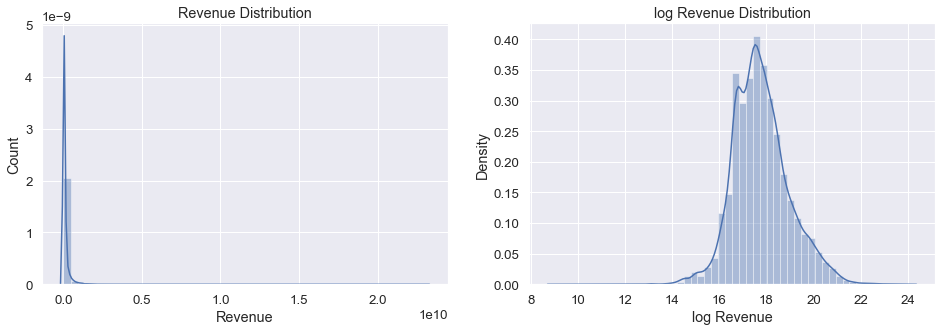

In [5]:
# Plot distributions of target variable

plt.figure(figsize=(16, 5))
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.2)


plt.subplot(121)
g = sns.distplot(train_df["totals.transactionRevenue"])
g.set_title("Revenue Distribution")
g.set_xlabel("Revenue")
g.set_ylabel("Count")

plt.subplot(122)
g1 = sns.distplot(np.log(train_df["totals.transactionRevenue"]+1.5))
g1.set_title("log Revenue Distribution")
g1.set_xlabel("log Revenue")
g1.set_ylabel("Density")

plt.subplots_adjust(hspace = 0.4, top = 0.85)

plt.show()

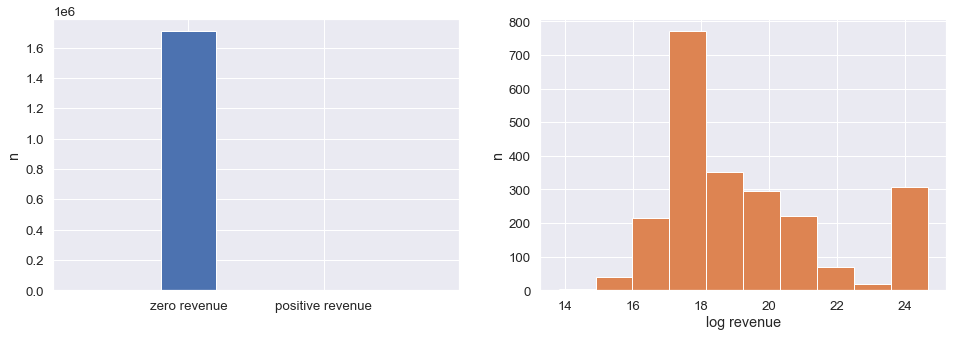

In [6]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16,5))

ax[0].bar([0,1],
          [len(train_df[train_df['trans_revenue']==0]), len(train_df[train_df['trans_revenue']!=0])],
          width=0.4, color=['C0','C1'])
ax[0].set_xlim(-1,2)
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['zero revenue', 'positive revenue'])
ax[0].set_ylabel('n')

ax[1].hist((train_df[train_df['trans_revenue']!=0]['trans_revenue']), color='C1')
ax[1].set_xlabel('log revenue')
ax[1].set_ylabel('n')

plt.show(fig)

In [3]:
train_no_revisit = train_df[train_df['visit_flag']=='no_revisit']
train_revisit_no_trans = train_df[train_df['visit_flag']=='revisit_no_trans']
train_revisit_with_trans = train_df[train_df['visit_flag']=='revisit_with_trans']

In [5]:
print(f"Customers who did not revisit: {len(train_no_revisit)}")
print(f"Customers who revisited but did not spend: {len(train_revisit_no_trans)}")
print(f"Customers who revisited and spent: {len(train_revisit_with_trans)}")

Customers who did not revisit: 1680674
Customers who revisited but did not spend: 25369
Customers who revisited and spent: 2294


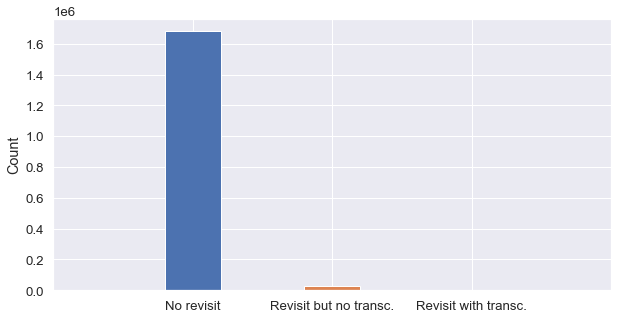

In [8]:
fig, ax = plt.subplots(figsize=(10,5))

ax.bar([0,1,2],
       [len(train_no_revisit),len(train_revisit_no_trans),len(train_revisit_with_trans)],
       width=0.4, color=['C0','C1','C2'])
ax.set_xlim(-1,3)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['No revisit', 'Revisit but no transc.', 'Revisit with transc.'])
ax.set_ylabel('Count')

plt.show(fig)

In [9]:
def three_bars(feature):
    """
    Make bar plots that compare no revisit, revisit no transc., revisit with transc. for categorical features.
    
    Parameters
    ----------
    feature : str
        Name of feature.
    """
    unique_vals = train_df[feature].unique()
    n_vals = len(unique_vals)

    val_counts_no_revisit = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_no_revisit[i] = len(train_no_revisit[train_no_revisit[feature].isnull()])
        else:
            val_counts_no_revisit[i] = len(train_no_revisit[train_no_revisit[feature]==unique_vals[i]])
    val_counts_no_revisit = np.sort(val_counts_no_revisit)[::-1]

    val_counts_revisit_no_trans = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_revisit_no_trans[i] = len(train_revisit_no_trans[train_revisit_no_trans[feature].isnull()])
        else:
            val_counts_revisit_no_trans[i] = len(train_revisit_no_trans[train_revisit_no_trans[feature]==unique_vals[i]])
    val_counts_revisit_no_trans = np.sort(val_counts_revisit_no_trans)[::-1]

    val_counts_revisit_with_trans = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_revisit_with_trans[i] = len(train_revisit_with_trans[train_revisit_with_trans[feature].isnull()])
        else:
            val_counts_revisit_with_trans[i] = len(train_revisit_with_trans[train_revisit_with_trans[feature]==unique_vals[i]])
    val_counts_revisit_with_trans = np.sort(val_counts_revisit_with_trans)[::-1]

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),  val_counts_no_revisit, alpha=0.8, color='#F97306')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('No revisit')

    ax[1].bar(np.arange(n_vals), val_counts_revisit_no_trans, alpha=0.8, color='#0343DF')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('Revisit but no transc.')

    ax[2].bar(np.arange(n_vals), val_counts_revisit_with_trans, alpha=0.8, color='#006400')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('Revisit with transc.')

    plt.show(fig)

In [10]:
def three_bars_OTHER(feature, unique_vals):
    """
    Make bar plots that compare no revisit, revisit no transc., revisit with transc., including OTHER.
    
    Parameters
    ----------
    feature : str
        Name of feature.
        
    unique_vals : list
        List of categories - must include 'OTHER' as the last item.
    """
    n_vals = len(unique_vals)

    val_counts_no_revisit = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_revisit_no_trans[i] = len(train_revisit_no_trans[train_revisit_no_trans[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_no_revisit[i] = len(train_no_revisit[train_no_revisit[feature]==unique_vals[i]])
            else:
                val_counts_no_revisit[i] = len(train_no_revisit) - np.sum(val_counts_no_revisit)
    val_counts_no_revisit = np.sort(val_counts_no_revisit)[::-1]
                

    val_counts_revisit_no_trans = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_revisit_no_trans[i] = len(train_revisit_no_trans[train_revisit_no_trans[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_revisit_no_trans[i] = len(train_revisit_no_trans[train_revisit_no_trans[feature]==unique_vals[i]])
            else:
                val_counts_revisit_no_trans[i] = len(train_revisit_no_trans) - np.sum(val_counts_revisit_no_trans) 
    val_counts_revisit_no_trans = np.sort(val_counts_revisit_no_trans)[::-1]

    val_counts_revisit_with_trans = np.zeros(n_vals)
    for i in range(n_vals):
        if pd.isnull(unique_vals[i]):
            val_counts_revisit_with_trans[i] = len(train_revisit_with_trans[train_revisit_with_trans[feature].isnull()])
        else:
            if unique_vals[i] != 'OTHER':
                val_counts_revisit_with_trans[i] = len(train_revisit_with_trans[train_revisit_with_trans[feature]==unique_vals[i]])
            else:
                val_counts_revisit_with_trans[i] = len(train_revisit_with_trans) - np.sum(val_counts_revisit_with_trans)
    val_counts_revisit_with_trans = np.sort(val_counts_revisit_with_trans)[::-1]

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    ax[0].bar(np.arange(n_vals),  val_counts_no_revisit, alpha=0.8, color='#F97306')
    ax[0].set_xticks(np.arange(n_vals))
    ax[0].set_xticklabels(unique_vals, rotation=90)
    ax[0].set_title('No revisit')

    ax[1].bar(np.arange(n_vals), val_counts_revisit_no_trans, alpha=0.8, color='#0343DF')
    ax[1].set_xticks(np.arange(n_vals))
    ax[1].set_xticklabels(unique_vals, rotation=90)
    ax[1].set_title('Revisit but no transc.')

    ax[2].bar(np.arange(n_vals), val_counts_revisit_with_trans, alpha=0.8, color='#006400')
    ax[2].set_xticks(np.arange(n_vals))
    ax[2].set_xticklabels(unique_vals, rotation=90)
    ax[2].set_title('Revisit with transc.')

    plt.show(fig)

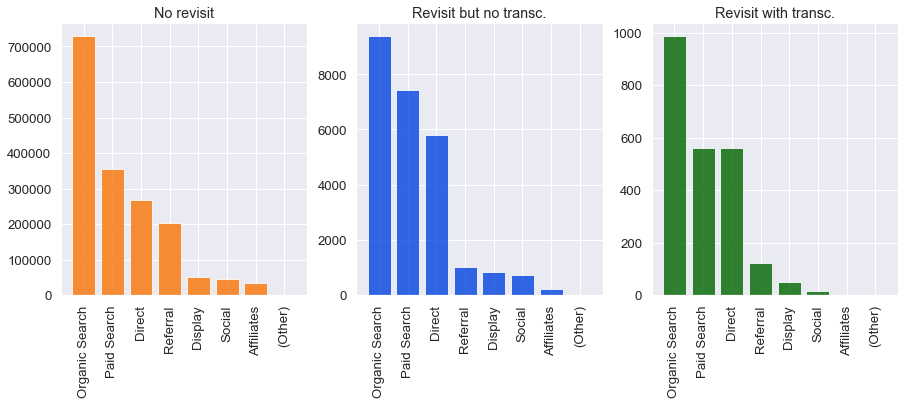

In [11]:
three_bars('channelGrouping')

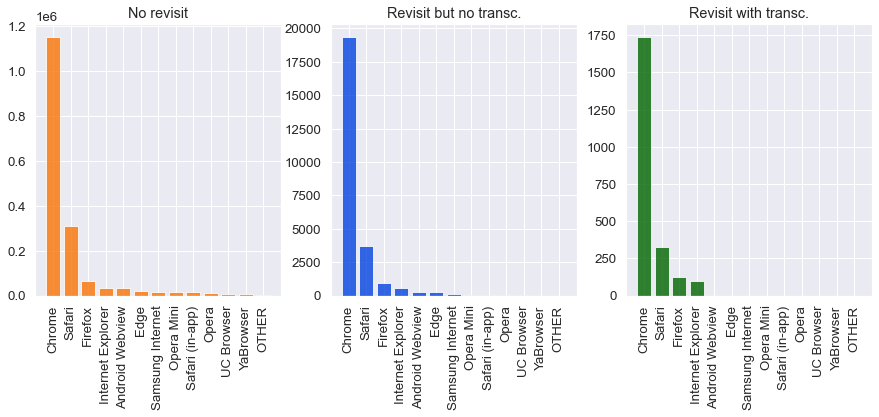

In [12]:
feature = 'device.browser'
value_counts = train_df[feature].value_counts(dropna=False)
unique_vals = value_counts[value_counts>2000].index.to_list()
unique_vals.append('OTHER')

three_bars_OTHER(feature, unique_vals)

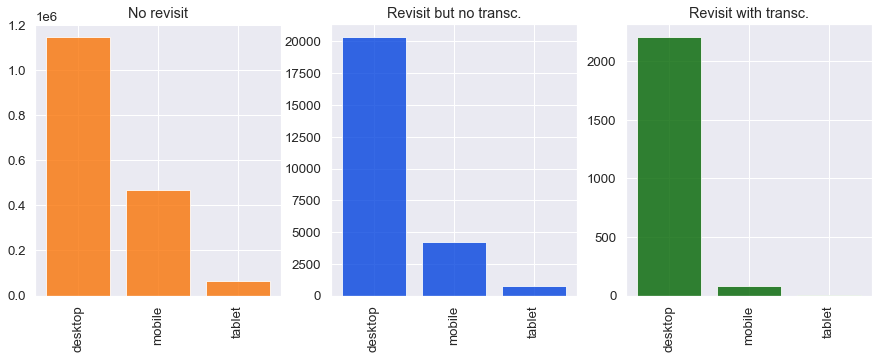

In [13]:
three_bars('device.deviceCategory')

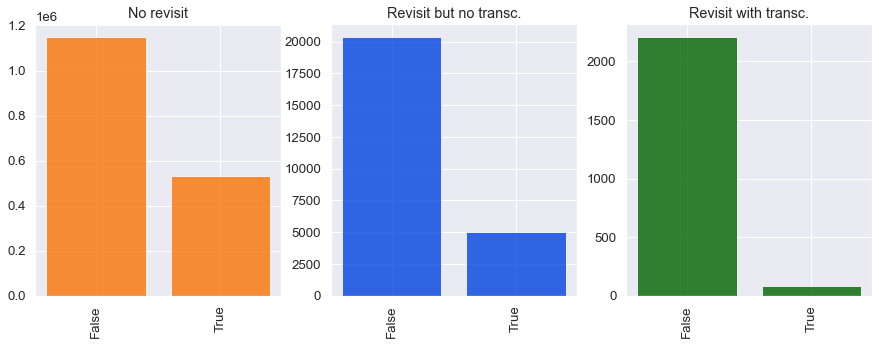

In [14]:
three_bars('device.isMobile')

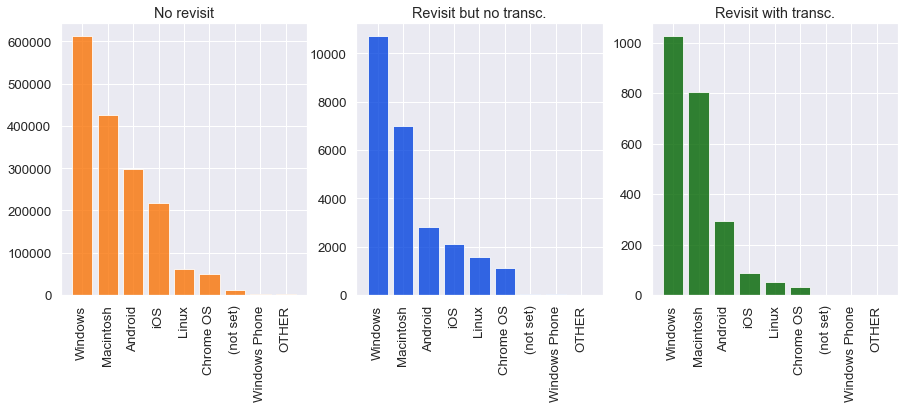

In [15]:
feature = 'device.operatingSystem'
value_counts = train_df[feature].value_counts(dropna=False)
unique_vals = value_counts[value_counts>1000].index.to_list()
unique_vals.append('OTHER')
three_bars_OTHER(feature, unique_vals)

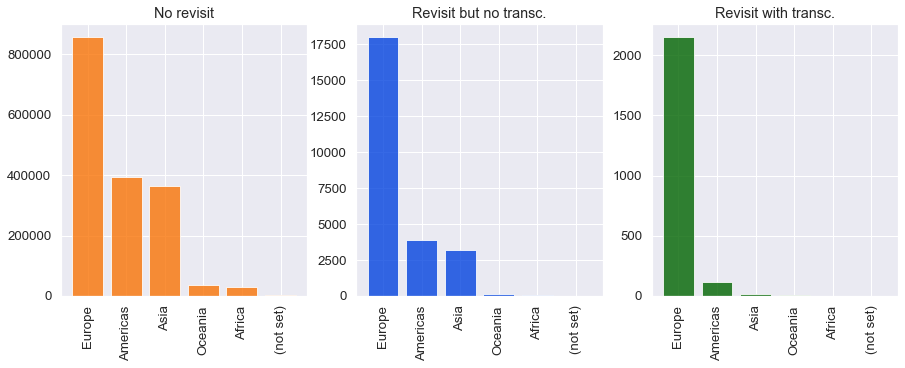

In [16]:
three_bars('geoNetwork.continent')

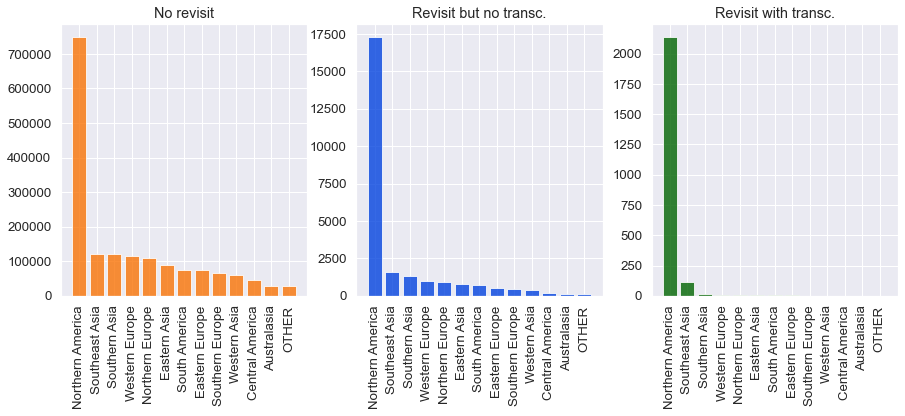

In [17]:
feature = 'geoNetwork.subContinent'
value_counts = train_df[feature].value_counts(dropna=False)
unique_vals = value_counts[value_counts>20000].index.to_list()
unique_vals.append('OTHER')
three_bars_OTHER(feature, unique_vals)

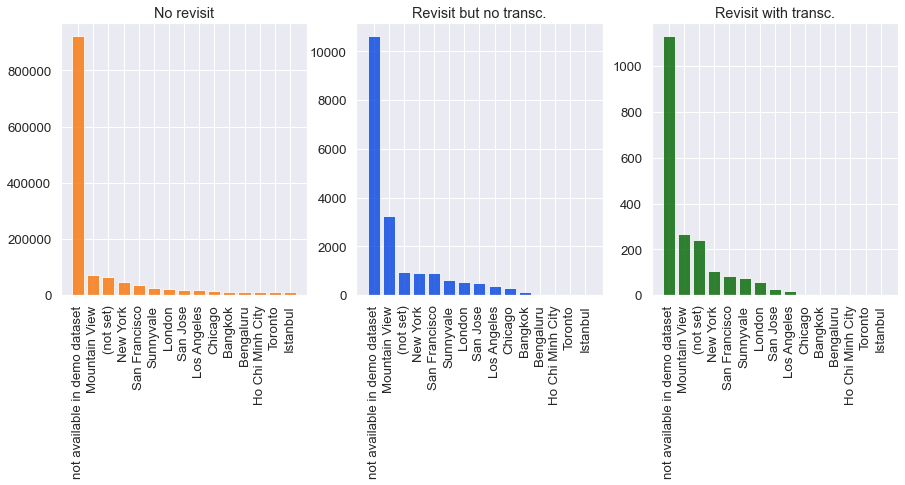

In [18]:
feature = 'geoNetwork.city'
value_counts = train_df[feature].value_counts(dropna=False)
unique_vals = value_counts[value_counts>5000].index.to_list()
unique_vals.append('OTHER')
unique_vals = unique_vals[:15]
three_bars_OTHER(feature, unique_vals)

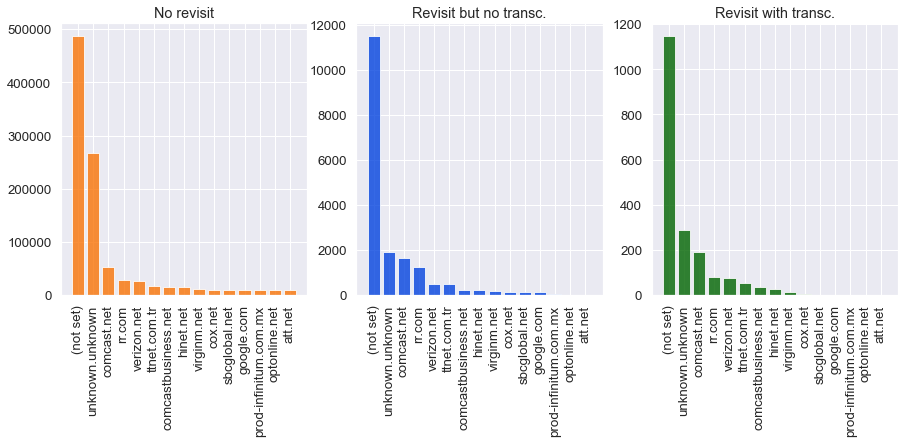

In [19]:
feature = 'geoNetwork.networkDomain'
value_counts = train_df[feature].value_counts(dropna=False)
unique_vals = value_counts[value_counts>2000].index.to_list()
unique_vals.append('OTHER')
unique_vals = unique_vals[:15]
three_bars_OTHER(feature, unique_vals)

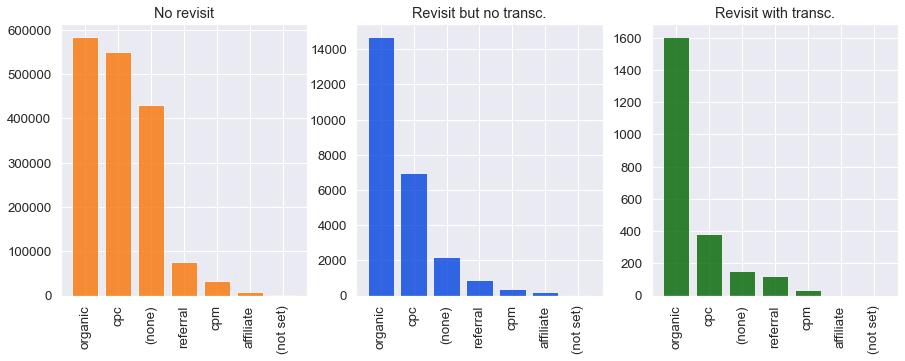

In [20]:
three_bars('trafficSource.medium')

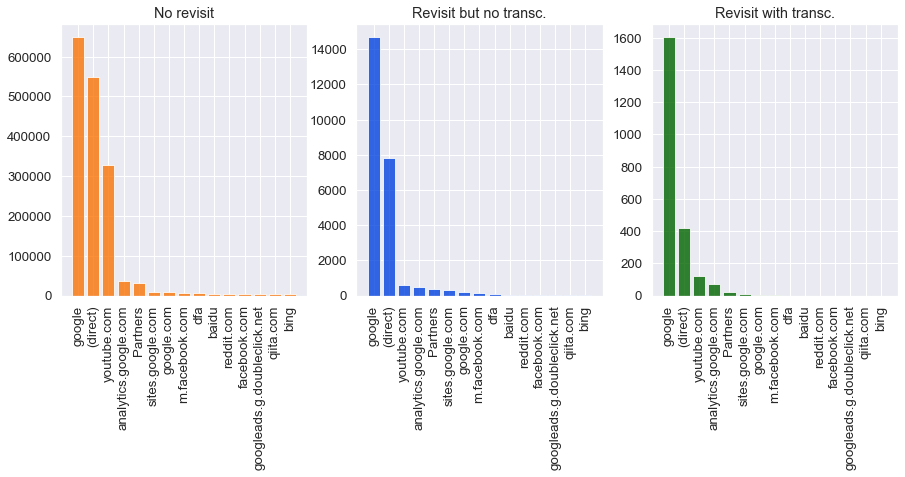

In [21]:
feature = 'trafficSource.source'
value_counts = train_df[feature].value_counts(dropna=False)
unique_vals = value_counts[value_counts>1200].index.to_list()
unique_vals.append('OTHER')
unique_vals = unique_vals[:15]
three_bars_OTHER(feature, unique_vals)

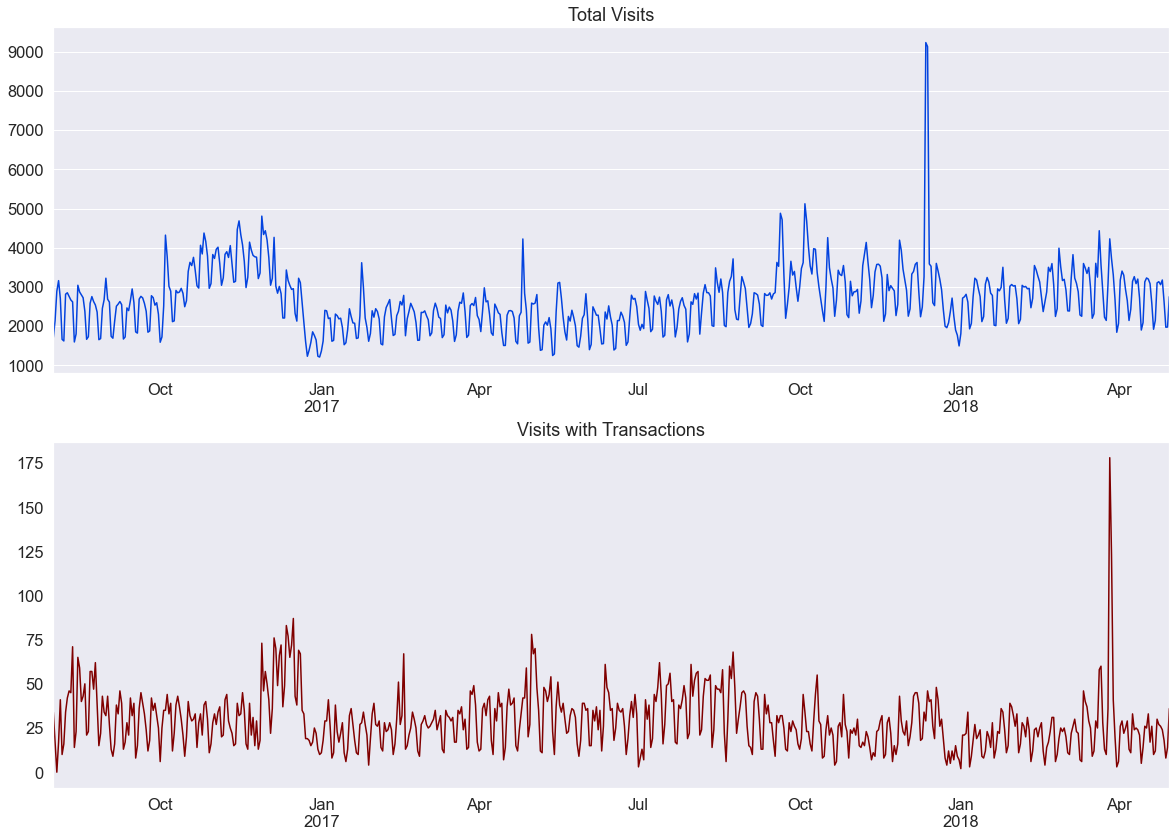

In [22]:
# Plots for count of visits and transactions based on time  

sns.set_context("poster")
sns.set_style("whitegrid")
sns.set(font_scale=1.5)

cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()

fig, ax = plt.subplots(2, 1, figsize=(20, 14))
cnt_srs["count"].plot(color='#0343DF', ax=ax[0])
cnt_srs["count of non-zero revenue"].plot(color='#800000', ax=ax[1])

for axes in ax:
    axes.set(xlabel=None)
    axes.grid(axis='x')

ax[0].set_title("Total Visits")
ax[1].set_title("Visits with Transactions")

plt.grid(False)
plt.show()

In [23]:
# splitting date and visitStartTime columns for further analysis 

def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["week_day"] = df['date'].dt.weekday #extracting week day
    df["month_day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df['visit_hour'] = (df['visitStartTime'].apply(lambda x: str(dt.datetime.fromtimestamp(x).hour))).astype(int)
    return df

In [25]:
train_df = date_process(train_df)
test_df = date_process(test_df)

In [26]:
#  VisitHour and weekday
date_sales = ['visit_hour', 'week_day']
cm = sns.color_palette("crest", as_cmap=True)
pd.crosstab(train_df[date_sales[0]], train_df[date_sales[1]]).style.background_gradient(cmap = cm)

week_day,0,1,2,3,4,5,6
visit_hour,,,,,,,
0,14985,15770,15716,14685,13577,9464,9907
1,14133,15030,15037,14124,12925,9163,9274
2,14037,14088,14331,13496,12264,8713,9041
3,12534,13072,13161,12352,11612,8120,8305
4,11438,11396,11754,11397,10450,7324,7764
5,10982,12802,11193,10365,9102,6719,7406
6,10205,14141,10583,9960,8076,6547,7987
7,10013,10088,10058,10045,7934,6836,8341
8,9375,9727,9735,9395,7570,6758,8180


<a id='4'></a>
## 5. Data Processing

In [46]:
df_summary(train_df)

Dataset Shape: (1708337, 36)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,int32,0,8,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1,date,datetime64[ns],0,638,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,...,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-11-03 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00,2016-09-02 00:00:00
2,fullVisitorId,object,0,1323730,9499785259412240342,3696906537737368442,5688512451361930466,9716453263501147451,5330453591145100432,4904559133238424046,...,6987021577579660288,4445454811831400414,7561246936334740030,6547469634605092577,6547469634605092577,0360986093646287740,3489007895192654976,7595651110869420038,7595651110869420038,4821951350451279762
3,visitId,int64,0,1665802,1472812272,1472856874,1472811524,1472823508,1472839619,1472872837,...,1472821960,1472805784,1472809600,1472848207,1478213813,1472830405,1472828240,1472816859,1472813052,1472821343
4,visitNumber,float64,0,457,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0
5,visitStartTime,float64,0,1667423,1472812272.0,1472856874.0,1472811524.0,1472823508.0,1472839619.0,1472872837.0,...,1472821960.0,1472805784.0,1472809600.0,1472848207.0,1478213813.0,1472830405.0,1472828240.0,1472816859.0,1472813052.0,1472821343.0
6,device.browser,int32,0,129,54,46,46,91,46,46,...,91,61,80,91,91,46,46,91,91,46
7,device.operatingSystem,int32,0,24,22,22,6,25,22,7,...,25,22,1,7,7,22,6,25,25,22
8,device.isMobile,bool,0,2,False,False,False,True,False,False,...,True,False,True,False,False,False,False,True,True,False
9,device.deviceCategory,int32,0,3,0,0,0,1,0,0,...,1,0,1,0,0,0,0,1,1,0


In [47]:
df_summary(test_df)

Dataset Shape: (236416, 33)


,Name,dtypes,Missing,Uniques,0 Value,1 Value,2 Value,3 Value,4 Value,5 Value,...,10 Value,11 Value,12 Value,13 Value,14 Value,15 Value,16 Value,17 Value,18 Value,19 Value
0,channelGrouping,int32,0,8,4,2,4,2,4,4,...,6,6,2,6,4,6,6,4,4,2
1,date,datetime64[ns],0,98,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,...,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00,2018-05-11 00:00:00
2,fullVisitorId,object,0,180305,7460955084541987166,460252456180441002,3461808543879602873,975129477712150630,8381672768065729990,2866297766347322467,...,5299820794845174508,7414906446453226824,4063440620410560213,3326540121689239742,7713658643915819491,7437323504893211921,9553181489247767015,4605774125139978152,2400060996995525389,3524623036868660621
3,visitId,int64,0,231431,1526099341,1526064483,1526067157,1526107551,1526060254,1526061951,...,1526087937,1526051687,1526081933,1526068491,1526040686,1526087525,1526044676,1526041980,1526039044,1526058521
4,visitNumber,float64,0,317,2.0,166.0,2.0,4.0,1.0,2.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,visitStartTime,float64,0,231692,1526099341.0,1526064483.0,1526067157.0,1526107551.0,1526060254.0,1526061951.0,...,1526087937.0,1526051687.0,1526081933.0,1526068491.0,1526040686.0,1526087525.0,1526044676.0,1526041980.0,1526039044.0,1526058521.0
6,device.browser,int32,0,50,46,46,46,46,61,46,...,46,46,46,46,91,46,46,46,46,46
7,device.operatingSystem,int32,0,21,1,7,3,25,22,22,...,6,3,22,6,7,7,7,22,7,7
8,device.isMobile,bool,0,2,True,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
9,device.deviceCategory,int32,0,3,1,0,0,1,2,0,...,0,0,0,0,0,0,0,0,0,0


<a id='4.1'></a>
## 5.1. Imputing Missing Values & Categorical Encoding

#### Imputing missing Values

In [36]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
test_df["totals.transactionRevenue"] = test_df["totals.transactionRevenue"].astype('float')

In [37]:
train_df['totals.pageviews'].fillna(0, inplace=True)
test_df['totals.pageviews'].fillna(0, inplace=True)

In [38]:
train_df['totals.timeOnSite'].fillna(0, inplace=True)
test_df['totals.timeOnSite'].fillna(0, inplace=True)

In [39]:
print("Total unique values: {0}".format(train_df['trafficSource.keyword'].nunique()))
print("Total records having 'nan' are : {0}".format(train_df['trafficSource.keyword'].astype(str).str.contains("nan").sum(axis=0)))
print("Total records having '(not provided)' are : {0}".format(train_df['trafficSource.keyword'].astype(str).str.contains("(not provided)").sum(axis=0)))

Total unique values: 4546
Total records having 'nan' are : 1052785
Total records having '(not provided)' are : 568933


In [40]:
# We will repalce the all 'nan','(not provided)' with 'others'
train_df['trafficSource.keyword'].replace(['nan','NaN','(not provided)'], 'others',inplace=True)
train_df['trafficSource.keyword'].fillna('others', inplace=True)

test_df['trafficSource.keyword'].replace(['nan','NaN','(not provided)'], 'others',inplace=True)
test_df['trafficSource.keyword'].fillna('others', inplace=True)

In [41]:
train_df['trafficSource.referralPath'].unique()

array([nan, '/corp/google.com/study/incentives/working-with-perks',
       '/a/google.com/google-merchandise-store/on-site-store', ...,
       '/intl/nl_ALL/yt/advertise/resources/optimizing-your-video-marketing-campaigns/',
       '/intl/ar/yt/advertise/how-it-works/',
       '/yt/lineups/ru/france.html'], dtype=object)

We will use label encoding later on this feature which will encode the nan values.

In [42]:
train_df['trafficSource.adwordsClickInfo.gclId'].unique()

array([nan,
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRE1NdtWc6_a2xY4pSI9-aluNvjM7Svy6GMhQ6OkljXoaAg268P8HAQ',
       'Cj0KEQjwxqS-BRDRgPLp0q2t0IUBEiQAgfMXRMY-4jVpxNIgDp8aIZEe5LD3Bbc0IeyLZg0bG5m2DpoaAsl88P8HAQ',
       ..., 'EAIaIQobChMIr-bexv7a2gIVT8fACh29kgGrEAEYASAAEgJ10PD_BwE',
       'EAIaIQobChMIseCEoPrb2gIV2E0rCh138AXjEAEYASAAEgKllPD_BwE',
       'CjwKCAjwwuvWBRBZEiwALXqjw4R4LcMff-LmynPteEZLSnClb6ULP8X-Iwq9Fn36t8hEZF6g67IfnRoCNmgQAvD_BwE'],
      dtype=object)

More than 95% of data is missing, hence we will drop this feature.

In [43]:
train_df['trafficSource.adwordsClickInfo.page'].unique()

array([nan, '1', '5', '4', '2', '3', '7', '9', '14', '6', '8', '12'],
      dtype=object)

More than 95% of data is missing, hence we will drop this feature.

In [44]:
train_df['trafficSource.adwordsClickInfo.slot'].unique()

array([nan, 'Top', 'RHS', 'Google Display Network'], dtype=object)

More than 95% of data is missing, hence we will drop this feature.

In [45]:
train_df['trafficSource.adContent'].unique()

array([nan, 'First Full Auto Template Test Ad', 'Full auto ad IMAGE ONLY',
       '{KeyWord:Google Brand Items}', '20% discount',
       'Google Merchandise', 'Display Ad created 3/11/14',
       'Ad from 11/3/16', 'Ad from 12/13/16',
       'Display Ad created 3/11/15', 'Full auto ad TEXT ONLY',
       'Ad from 11/7/16', 'Full auto ad TEXT/NATIVE', 'LeEco_1a',
       "{KeyWord:Google Men's T-Shirts}",
       'Full auto ad with Primary Color', 'JD_5a_v1',
       'Full auto ad NATIVE ONLY', 'free shipping',
       'Official Google Merchandise - Fast Shipping',
       '{KeyWord:Google Branded Outerwear}', 'GA Help Center',
       'Free Shipping!', 'Swag w/ Google Logos',
       'Google Merchandise Collection', 'Google Online Store',
       'visit us again', 'Display Ad created 11/17/14',
       '{KeyWord:Want Google Stickers?}', '{KeyWord:Google Merchandise}',
       '{KeyWord:Google Drinkware}', '{KeyWord:Google Branded Gear}',
       '{KeyWord:Google Branded Apparel}',
       '{KeyWord

We will use label encoding later on this feature which will encode the nan values.

In [46]:
train_df['totals.transactions'].fillna(0, inplace=True)
test_df['totals.transactions'].fillna(0, inplace=True)

In [47]:
train_df['totals.transactionRevenue'].fillna(0, inplace=True)
test_df['totals.transactionRevenue'].fillna(0, inplace=True)

In [48]:
# Dropping columns after above analysis

cols_to_drop = ['totals.totalTransactionRevenue', 'trafficSource.adwordsClickInfo.gclId',
                'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.page']

for feature in cols_to_drop:
    if feature in test_df.columns:
        del test_df[feature]
        
    if feature in train_df.columns:
        del train_df[feature]

In [18]:
# Convert boolean feature

train_df['device.isMobile'] = train_df['device.isMobile'].astype(bool)
test_df['device.isMobile']  = test_df['device.isMobile'].astype(bool)

In [19]:
# Convert numerical features to float

numeric_feat = ['visitNumber','visitStartTime','totals.hits','totals.pageviews',\
                'totals.timeOnSite','totals.transactions','totals.transactionRevenue']

for col in numeric_feat:
    train_df[col].fillna(0,inplace=True)
    train_df[col] = train_df[col].astype('float')
    
    test_df[col].fillna(0,inplace=True)
    test_df[col] = test_df[col].astype('float')
    

In [20]:
# Encoding categorical features

from sklearn.preprocessing import LabelEncoder

start = dt.datetime.now()

categorical_feat = ['channelGrouping','device.browser','device.operatingSystem','device.deviceCategory',\
'geoNetwork.continent','geoNetwork.subContinent','geoNetwork.country','geoNetwork.region','geoNetwork.metro',\
'geoNetwork.city','geoNetwork.networkDomain', 'trafficSource.campaign','trafficSource.source',\
'trafficSource.medium','trafficSource.keyword','trafficSource.referralPath', 'trafficSource.adContent']

for feature in categorical_feat:
    
    label_encoder = LabelEncoder() # intitalizing label encoder object
    
    label_encoder.fit(list(train_df[feature].values.astype('str')) + list(test_df[feature].values.astype('str')))
                                                             # fit with list of variables in that feature
    
    train_df[feature] = label_encoder.transform(list(train_df[feature].values.astype('str'))) # transforming that feature
    test_df[feature]  = label_encoder.transform(list(test_df[feature].values.astype('str')))
    print("Feature : {0} label-encoded".format(feature))

print("Time taken to run this cell :", dt.datetime.now() - start)    

Feature : channelGrouping label-encoded
Feature : device.browser label-encoded
Feature : device.operatingSystem label-encoded
Feature : device.deviceCategory label-encoded
Feature : geoNetwork.continent label-encoded
Feature : geoNetwork.subContinent label-encoded
Feature : geoNetwork.country label-encoded
Feature : geoNetwork.region label-encoded
Feature : geoNetwork.metro label-encoded
Feature : geoNetwork.city label-encoded
Feature : geoNetwork.networkDomain label-encoded
Feature : trafficSource.campaign label-encoded
Feature : trafficSource.source label-encoded
Feature : trafficSource.medium label-encoded
Feature : trafficSource.keyword label-encoded
Feature : trafficSource.referralPath label-encoded
Feature : trafficSource.adContent label-encoded
Time taken to run this cell : 0:00:42.105826


<a id='4.2'></a>
## 5.2. Feature Engineering

In [26]:
# https://stackoverflow.com/questions/52747805/how-to-get-rid-of-nested-column-names-in-pandas-from-group-by-aggregation

def get_train_features(df):
       
    temp_df = df.loc[:, ['fullVisitorId', 'trans_revenue', 'revisit']]
    
    df_maxdate = max(df['date'])
    df_mindate = min(df['date'])
    
    feat_df = df.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], 
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())], 
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],
            'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], 
            'device.browser':           [('browser' , lambda x: x.dropna().max())],
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())],
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],    
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())], 
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),    
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),    
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),    
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     
                                         ('hits_min'  , lambda x: x.dropna().min()),     
                                         ('hits_max'  , lambda x: x.dropna().max()),     
                                         ('hits_mean' , lambda x: x.dropna().mean())],  
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], 
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], 
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], 
            'week_day':                 [('week_day_max' , lambda x: x.dropna().max())],
            'month_day':                [('month_day_max' , lambda x: x.dropna().max())],
            'month':                    [('month_max' , lambda x: x.dropna().max())],
            'visit_hour':               [('visit_hour_max' , lambda x: x.dropna().max())]   
                                        })

    
    # Dropping parent level of  each feature 
    feat_df.columns = feat_df.columns.droplevel() 
    
    # Merging the features and target columns
    merged_df = pd.merge(feat_df, temp_df , left_on='fullVisitorId', right_on='fullVisitorId') 
    
    return merged_df

In [27]:
start = dt.datetime.now()

train_feat = get_train_features(train_df)

print("Time taken to run this cell :", dt.datetime.now() - start)

Time taken to run this cell : 1:26:53.206042


In [28]:
train_feat.head()

,fullVisitorId,networkDomain,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,...,visitStartTime_counts,isMobile,visitNumber_max,transactions,week_day_max,month_day_max,month_max,visit_hour_max,trans_revenue,revisit
0,0000000259678714014,42446,579,7,102,74,4,3590,218,114,...,2,False,2.0,0.0,1,28,11,5,0.0,0
1,0000000259678714014,42446,579,7,102,74,4,3590,218,114,...,2,False,2.0,0.0,1,28,11,5,0.0,0
2,0000010278554503158,45417,1027,7,126,499,4,3590,146,114,...,1,False,1.0,0.0,3,20,10,11,0.0,0
3,0000020424342248747,26916,456,22,0,235,4,3590,159,0,...,1,False,1.0,0.0,2,30,11,13,0.0,0
4,0000027376579751715,8445,1027,7,126,499,4,3590,218,0,...,1,False,1.0,0.0,5,11,2,7,0.0,0


In [29]:
train_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1708337 entries, 0 to 1708336
Data columns (total 38 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   fullVisitorId          object 
 1   networkDomain          int32  
 2   city                   int32  
 3   operatingSystem        int32  
 4   metro                  int32  
 5   region                 int32  
 6   channelGrouping        int32  
 7   referralPath           int32  
 8   country                int32  
 9   source                 int32  
 10  medium                 int32  
 11  keyword                int32  
 12  browser                int32  
 13  deviceCategory         int32  
 14  continent              int32  
 15  subcontinent           int32  
 16  timeOnSite_sum         float64
 17  timeOnSite_min         float64
 18  timeOnSite_max         float64
 19  timeOnSite_mean        float64
 20  pageviews_sum          float64
 21  pageviews_min          float64
 22  pageviews_max     

In [21]:
def get_test_features(df):
    
   
    df_maxdate = max(df['date'])
    df_mindate = min(df['date'])
    
    temp_df = df.groupby('fullVisitorId').agg({
            'geoNetwork.networkDomain': [('networkDomain' , lambda x: x.dropna().max())], 
            'geoNetwork.city':          [('city' , lambda x: x.dropna().max())],  
            'device.operatingSystem':   [('operatingSystem' , lambda x: x.dropna().max())],
            'geoNetwork.metro':         [('metro' , lambda x: x.dropna().max())], 
            'geoNetwork.region':        [('region' , lambda x: x.dropna().max())],
            'channelGrouping':          [('channelGrouping' , lambda x: x.dropna().max())],
            'trafficSource.referralPath': [('referralPath' , lambda x: x.dropna().max())],
            'geoNetwork.country':       [('country' , lambda x: x.dropna().max())],    
            'trafficSource.source':     [('source' , lambda x: x.dropna().max())],   
            'trafficSource.medium':     [('medium' , lambda x: x.dropna().max())],   
            'trafficSource.keyword':    [('keyword', lambda x: x.dropna().max())], 
            'device.browser':           [('browser' , lambda x: x.dropna().max())],
            'device.deviceCategory':    [('deviceCategory', lambda x: x.dropna().max())],
            'geoNetwork.continent':     [('continent' , lambda x: x.dropna().max())],    
            'geoNetwork.subContinent':  [('subcontinent' , lambda x: x.dropna().max())], 
            'totals.timeOnSite':        [('timeOnSite_sum'  , lambda x: x.dropna().sum()),    
                                         ('timeOnSite_min'  , lambda x: x.dropna().min()),    
                                         ('timeOnSite_max'  , lambda x: x.dropna().max()),    
                                         ('timeOnSite_mean' , lambda x: x.dropna().mean())],  
            'totals.pageviews':         [('pageviews_sum'  , lambda x: x.dropna().sum()),     
                                         ('pageviews_min'  , lambda x: x.dropna().min()),     
                                         ('pageviews_max'  , lambda x: x.dropna().max()),     
                                         ('pageviews_mean' , lambda x: x.dropna().mean())],  
            'totals.hits':              [('hits_sum'  , lambda x: x.dropna().sum()),     
                                         ('hits_min'  , lambda x: x.dropna().min()),     
                                         ('hits_max'  , lambda x: x.dropna().max()),     
                                         ('hits_mean' , lambda x: x.dropna().mean())],  
            'visitStartTime':           [('visitStartTime_counts' , lambda x: x.dropna().count())], 
            'device.isMobile':          [('isMobile' ,  lambda x: x.dropna().max())], 
            'visitNumber':              [('visitNumber_max' , lambda x: x.dropna().max())],  
            'totals.transactions' :     [('transactions' , lambda x:x.dropna().sum())], 
            'week_day':                 [('week_day_max' , lambda x: x.dropna().max())],
            'month_day':                [('month_day_max' , lambda x: x.dropna().max())],
            'month':                    [('month_max' , lambda x: x.dropna().max())],
            'visit_hour':               [('visit_hour_max' , lambda x: x.dropna().max())]   
                                        })
    
    temp_df.columns = temp_df.columns.droplevel() 
    
    return temp_df

In [27]:
test_feat = get_test_features(test_df)

In [29]:
# Converting the id which has been indexed into a column

test_feat['fullVisitorId'] = test_feat.index

In [30]:
# Set target in test as empty

test_feat['trans_revenue'] = np.nan
test_feat['revisit'] = np.nan

In [31]:
test_feat.reset_index(drop=True, inplace=True)

In [32]:
test_feat.head()

,networkDomain,city,operatingSystem,metro,region,channelGrouping,referralPath,country,source,medium,...,isMobile,visitNumber_max,transactions,week_day_max,month_day_max,month_max,visit_hour_max,fullVisitorId,trans_revenue,revisit
0,0,391,7,69,37,4,0,200,62,5,...,False,1.0,0.0,0,13,8,8,0000018966949534117,NaN,NaN
1,0,502,1,81,268,2,0,200,0,0,...,True,1.0,0.0,2,13,6,6,0000039738481224681,NaN,NaN
2,0,502,21,81,268,4,0,200,62,5,...,True,1.0,0.0,6,3,6,10,0000073585230191399,NaN,NaN
3,13806,502,18,81,268,4,0,185,62,5,...,False,1.0,0.0,2,6,6,12,0000087588448856385,NaN,NaN
4,13499,502,1,81,268,4,0,163,62,5,...,True,1.0,0.0,0,21,5,22,0000149787903119437,NaN,NaN


In [43]:
test_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180305 entries, 0 to 180304
Data columns (total 38 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   networkDomain          180305 non-null  int32  
 1   city                   180305 non-null  int32  
 2   operatingSystem        180305 non-null  int32  
 3   metro                  180305 non-null  int32  
 4   region                 180305 non-null  int32  
 5   channelGrouping        180305 non-null  int32  
 6   referralPath           180305 non-null  int32  
 7   country                180305 non-null  int32  
 8   source                 180305 non-null  int32  
 9   medium                 180305 non-null  int32  
 10  keyword                180305 non-null  int32  
 11  browser                180305 non-null  int32  
 12  deviceCategory         180305 non-null  int32  
 13  continent              180305 non-null  int32  
 14  subcontinent           180305 non-nu

In [34]:
train_feat.to_pickle('train_feat.pkl')
test_feat.to_pickle('test_feat.pkl')

In [ ]:
train_df = pd.read_pickle(r'train_feat.pkl')
test_df = pd.read_pickle(r'test_feat.pkl')